# Residential Coverage Analysis 

Created code to do the following:
- Create OSMNX network
- Create isochrones that approximate .5 miles using network analysis
- Produce dissolved Isochrones areas for each transit route 
- Divide dissolved isochrone areas into voronoi polygons for each transit route. 
- Create intersection of voronoi polygons and the block group areas that fall within them. 
- Calculate the proportion of block group area that falls within isochrone/ Voronoi polygon area. 
- Multiply the block group total population figure by the proportion of area within the isochrone. 
- Sum the calculated population within isochrone estimates and sum these population figures for all of 
  the intersecting, clipped block group areas within each voronoi polygon. 


##### See Also:
- https://pythoncharmers.com/blog/travel-distance-python-with-geopandas-folium-alphashape-osmnx-buffer.html
- http://kuanbutts.com/2017/12/16/osmnx-isochrones/
- https://github.com/gboeing/osmnx-examples/blob/main/notebooks/13-isolines-isochrones.ipynb
- https://autogis-site.readthedocs.io/en/latest/notebooks/L6/01_network_analysis.html


In [1]:
import os
import geopandas as gpd
import osmnx as ox
import matplotlib.pyplot as plt
import networkx as nx
import fiona
from descartes import PolygonPatch
from shapely.geometry import Point, LineString, Polygon
from scipy.spatial import Voronoi
import numpy as np
import shapely
import time
from IPython.display import display

ox.config(log_console=True, use_cache=True)
ox.__version__

'1.1.2'

2021-12-29 23:15:14 Configured OSMnx 1.1.2
2021-12-29 23:15:14 HTTP response caching is on


In [2]:
#For graphing features in jupyter notebook:
%matplotlib inline
# ox.config(log_console=True, use_cache=True)
# ox.__version__

In [3]:
PROJECT_FOLDER = r"/Users/calvindechicago/Documents/GitHub/JWA_2021"
COUNTY_POLYGON = os.path.join(PROJECT_FOLDER, "Data", "osm_county_polygon.gpkg" )
STUDY_AREA = "/Users/calvindechicago/Documents/GitHub/JWA_2021/code_outputs/route2_and_max_yellow/route2_max_yellow_buffer_poly.gpkg"
ROUTE_2_STOPS = '/Users/calvindechicago/Documents/GitHub/JWA_2021/data/Data_from_JWA/Route2_Stops.shp'
MAX_YELLOW_STOPS = '/Users/calvindechicago/Documents/GitHub/JWA_2021/data/Data_from_JWA/MAX_Yellow_stops.shp'


In [4]:
# Get the boundary polygon for the city or county. This polygon will be used to pull network and POIs
county_poly = ox.geocoder.geocode_to_gdf('Multnomah County')
county_proj = ox.project_gdf(county_poly,4326)

2021-12-29 23:15:14 Retrieved response from cache file "cache/8cf5ce47f3c71ddf2f130625dfbd35014712c804.json"
2021-12-29 23:15:14 Created GeoDataFrame with 1 rows from 1 queries
2021-12-29 23:15:14 Projected GeoDataFrame to 4326


<AxesSubplot:>

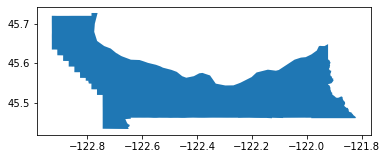

In [5]:
# Plot County geometry
county_proj.plot()

In [ ]:
# Export County Geometry

county_proj.to_file(COUNTY_POLYGON, layer='county_poly', driver="GPKG")

In [6]:
# Use this polygon to pull network in osmnx

polygon = county_proj['geometry'].iloc[0]

In [ ]:
# PULL NETWORK
# NOTE: Setting network type is important, and analysis on the network failed when I did not set the network type. 

network_type='walk'

G = ox.graph_from_polygon(polygon,  network_type=network_type)

# print('Making the graph undirected')
# G = G.to_undirected()


2021-12-29 23:15:25 Projected GeoDataFrame to +proj=utm +zone=10 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs
2021-12-29 23:15:25 Projected GeoDataFrame to epsg:4326
2021-12-29 23:15:25 Projected GeoDataFrame to +proj=utm +zone=10 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs
2021-12-29 23:15:25 Projected GeoDataFrame to epsg:4326
2021-12-29 23:15:25 Requesting data within polygon from API in 1 request(s)
2021-12-29 23:15:26 Retrieved response from cache file "cache/1540e6335ee5fbc9efcce76059b6fd0d604fa035.json"
2021-12-29 23:15:26 Got all network data within polygon from API in 1 request(s)
2021-12-29 23:15:26 Creating graph from downloaded OSM data...
2021-12-29 23:15:34 Created graph with 385673 nodes and 841414 edges
2021-12-29 23:15:39 Added length attributes to graph edges
2021-12-29 23:15:40 Identifying all nodes that lie outside the polygon...


In [ ]:
# Project the graph to UTM 
# osmnx automatically determines correct UTM zone and projects the graph. 
# Unit: Meters

G = ox.project_graph(G)

# Plot graph
fig, ax = ox.plot_graph(G)


In [ ]:
# Set travel speed and desired isochrone radius 

travel_speed = 4.5  # walking speed in km/hour (about 2.8 mph)
miles = .5


In [ ]:
# Add an edge attribute for time in minutes required to traverse each edge

# For more info on networkx and graph.edges function used here, see:
# https://networkx.org/documentation/stable/reference/classes/generated/networkx.Graph.edges.html

meters_per_minute = travel_speed * 1000 / 60 #km per hour to m per minute
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute




In [ ]:
# - Simple conversion function that determines the travel time 
# needed to travel a given distance in (Miles) at a given speed (in KPH). 
# - It takes as inputs a distance (in Miles) and travel speed (KPH)
# - The distance provided sets the network based travel radius to create isochrones. 
# - The travel speed given approximates the speed of a given mode, such as bicycling, walking, or transit. 
# - The trip time produced is appended to an empty list to work with
# the isochrone creation script written by Geoff Boeing. 


def kph_dist_calc(travel_speed, miles):
    dist_kilometers = miles * 1.60934
    trip_time = []
    trip_time.append((dist_kilometers / travel_speed)*60)
    return(trip_time)
    

# Run function with inputs defined in earlier cell    
trip_time = kph_dist_calc(travel_speed, miles)



In [ ]:
# Future functions require the trip time value be numeric, not a list. 

trip_time = trip_time[0]
trip_time

In [ ]:
# Create Geodataframe from graph edges to view data

gdf_edges = ox.graph_to_gdfs(G, nodes=False, edges=True)
gdf_nodes = ox.graph_to_gdfs(G, nodes=True, edges=False)

In [ ]:
# Geopackage does not accept columns with lists as values. Iterate over invalid columns and convert to strings:
invalid_cols = ['lanes', 'maxspeed', 'name', 'oneway', 'osmid', 'highway', 'est_width', 'service', 'access', 
               'bridge', 'ref','tunnel', 'junction', 'landuse', 'width', 'area']
for col in invalid_cols:
    gdf_edges[col] = gdf_edges[col].astype(str)

In [ ]:
#EXPORT EDGES to GEOPACKAGE

gdf_edges_filepath ="/Users/calvindechicago/Documents/GitHub/JWA_2021/code_outputs/edges.gpkg"
gdf_edges.to_file(gdf_edges_filepath, layer='edges', driver="GPKG")

In [ ]:
# Read in Bus Stops to geodataframe

route_2_stops = gpd.read_file(ROUTE_2_STOPS)
max_yellow_stops = gpd.read_file(MAX_YELLOW_STOPS)

#ROUTE_2_STOPS_TEST = '/Users/calvindechicago/Documents/GitHub/JWA_2021/data/route_2_stops_test/route_2_stops_test.gpkg'
#ROUTE_2_STOPS_TEST = '/Users/calvindechicago/Documents/GitHub/JWA_2021/data/route_2_stops_test/route_2_stops_test_v2.gpkg'


#route_2_stops = gpd.read_file(ROUTE_2_STOPS_TEST, layer='route_2_stops_test')
#route_2_stops = gpd.read_file(ROUTE_2_STOPS_TEST, layer='route_2_stops_test_v2')



In [ ]:
# Merge two bus stop files together
all_stops = route_2_stops.append(max_yellow_stops)

In [ ]:
# Plot merged bus stops
all_stops.plot()

In [ ]:
# Project route_2_stops to UTM CRS of graph
all_stops = all_stops.to_crs(epsg=32610)



In [ ]:
# Export the merged all stops 

all_stops_file ="/Users/calvindechicago/Documents/GitHub/JWA_2021/code_outputs/all_stops.gpkg"
all_stops.to_file(all_stops_file, layer='all_stops', driver="GPKG")

# Methodized Functions
#### The below functions do the following:
- Calculate isochrones for each transit stop using osmnx.
- Split dissolved route isochrones into voronoi polygons, which represent the residential coverage area for each transit stop. 
- Calculate population stats for each residential coverage area. 
- Export files to Geojson for use with Leaflet

In [ ]:
# Function that creates dissolved isochrone layer for each 

def create_isochrones(transit_stops, export_name='dissolved_iso', export=True):
    
    """
    This function Assumes that a graph 'G' has been created and processed to include a 'time' value used to 
    calculate the amount of time to traverse an edge. The function assumes that a 'trip_time' variable has also
    been set. 
    
    The function first finds the nearest network node to each transit stop. It then creates an isochrone using 
    the nearest nodes. 
    
    The isochrones assume a constant walking speeds along the walkable street network and do not account 
    for traffic signals, or other impedances. 
    
 
        params: transit_stops: geodataframe of point data representing transit stops.
        params: export_name: string representing name that will be appended to end of file output name
        export: True if you want to export dissolved isochrone polygon or multipolygon to disk. False if you do
                not want to export. 
        
        returns: This function returns a geodataframe for the dissolved isochrones. 
    
    
    """
    
    transit_stops = transit_stops.to_crs(epsg=32610)
    
    # Get nearest osmnx network node to each bus stop for network analysis
    nearest_node = ox.distance.nearest_nodes(G, transit_stops['geometry'].x, transit_stops['geometry'].y )
    #nearest_nodes.append(nearest_node)

    print("The nearest nodes are: \n ")
    nearest_node
    
    # Make ISOCHRONES for each Transit Stop
    isochrone_polys = []
    for node in nearest_node:
        # make the isochrone polygons
        subgraph = nx.ego_graph(G, node, radius=trip_time, distance='time')
        node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
        bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
        isochrone_polys.append(bounding_poly)

    len(node_points)
    
    #Create geodataframe of isochrones for export
    isochrone_gdf = gpd.GeoDataFrame(isochrone_polys, geometry=0)
    
    #SET CRS
    isochrone_gdf = isochrone_gdf.set_crs(epsg=32610)
    
    # Dissolve the Isochrones
    # Geopandas requires a dissolve field. Create new field and set every row to 1. 
    isochrone_gdf['dissolvefield']= 1
    iso_dissolved = isochrone_gdf.dissolve(by='dissolvefield')
    
    #SET CRS
    iso_dissolved = iso_dissolved.set_crs(epsg=32610)

    if export:
        # Export Isochrone layer
        # TODO - find solution to dynamically name output layer name. 
        print(f"\n\n***************** EXPORTING DISSOLVED ISOCHRONES FOR {export_name}")
        isochrone_export_3="/Users/calvindechicago/Documents/GitHub/JWA_2021/code_outputs/dissolved_isos.gpkg"
        iso_dissolved.to_file(isochrone_export_3, layer=f'isos_dissolved_{export_name}', driver="GPKG")
    else:
        pass
    
    return iso_dissolved;


In [ ]:
# Function for creating residential coverage polygons from points
# **If a route is bidirectional with separate stations for each direction, 
# each direction's collective set of stops should have their own set of corresponding
# voronoi polygons, unaffected by other routes, lines, and directions.  


def create_residential_coverage_areas(dissolved_isos, transit_stops, export_name='clipped_voronoi', export=True):
    """
    This function creates residential coverage areas by:
    -  1/2 mile dissolved isochrones, aka travel sheds, around all transit stops for a single route. 
    -  Voronoi polygons are then created for each bus stop on the route
    -  These voronoi polygons are then clipped to the area within the 1/2 mile isochrones
    -  Each of these voronoi polygons represents the residential coverage area for a given stop on a route.
    -  The isochrone polygons contain all of the points within the walkable street network that can be reached
    walking (at about about 2.8 mph) The analysis assumes a constant walking speed and does not account for stop 
    lights or other impedences. 
    - Many of the bus stops will contain 1/2 mile isochrones that overlap with other same route bus stops' 
    1/2 mile isochrone. 
    - To ensure that the overlapping 1/2 mile isochrone areas are not double counted, The entire area covered
    by all of the isochrones for the route is segmented into separate polygons for each transit stop, called voronoi 
    polygons. Each transit stop's vorronoi polygon represents every point within the isochrone area that is closer to 
    the given transit stop than any other transit stop on the route.
    
        params: dissolved_isos: geodataframe representing dissolved isochrones. 
        params: transit_stops: geodataframe of point data representing transit stops.
        params: export_name: string representing name that will be appended to end of file output name
        
        returns: This returns a geodataframe for the clipped voronoi polygons. 
    
    """
    
    
    #Get geometry column of transit stops geodataframe
    transit_stops = transit_stops['geometry']
    
    transit_stops = transit_stops.to_crs(epsg=32610)

    
    # Create array of coordinates for all transit stops
    x = transit_stops.geometry.x.values
    y = transit_stops.geometry.y.values
    coords = np.vstack((x, y)).T
    
    print('\n Number of coordinate pairs: \n ')
    print(len(coords))
    print("\n")
    
    # The shapely Voronoi tool has an issue with creating polygons for some outlying points. 
    # This can be resolved by creating the vertices for an enlarged bounding box. 
    # This isn't a perfect solution, but should work well enough for this application. 
    # Here I use +/- 5000 meters. 
    # See Stackoverflow for notes:
    # # FROM: https://stackoverflow.com/questions/20515554/colorize-voronoi-diagram/20678647#20678647
    def enlarged_bounding_box(points):
        x_coordinates, y_coordinates = zip(*points)

        return [(min(x_coordinates)-5000,min(y_coordinates)-5000), (max(x_coordinates)+5000, max(y_coordinates)+5000), 
                (min(x_coordinates)-5000, max(y_coordinates)+5000 ), (max(x_coordinates)+5000, min(y_coordinates)-5000)]

    # Run enlarged_bbox function. This function creates an enlarged bounding box around the transit route points
    bbox = enlarged_bounding_box(coords)
    
    # Create enlarged_bbox Geodataframe. This creates a geodataframe with two columns,
    # one with x coordinates and another with y coordinates. 
    gdf_bbox = gpd.GeoDataFrame(bbox)

    # Create a single column geodataframe with a geometry column with the enlarged bbox coordinates
    bbox_gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(gdf_bbox[0], gdf_bbox[1]))
   
    # Create array of points that can be added to bus stop points
    bbox_coords = []
    for point in bbox_gdf['geometry']:
        print(point.coords[:][0])
        bbox_coords.append(point.coords[:][0])


    
    # Append enlarged bbox vertices to points
    print('Coords shape before adding enlarged bounding box vertices:\n')
    print(coords.shape)
    coords = np.append(coords, bbox_coords, axis = 0)
    print('Coords shape after adding enlarged bounding box vertices:\n')
    print(coords.shape)
    
    print("Creating Polygons from shapely Voronoi object...")
    # Run Shapely voronoi tool on original points, with enlarged bounding box vertices added to point list
    vor = Voronoi(coords)
    
    
    # Create polygons from Shapely Voronoi data 
    lines = [shapely.geometry.LineString(vor.vertices[line]) for line in vor.ridge_vertices if -1 not in line]
    polys = shapely.ops.polygonize(lines)
    voronois = gpd.GeoDataFrame(geometry=gpd.GeoSeries(polys))
    lines = [LineString(vor.vertices[line]) for line in vor.ridge_vertices if -1 not in line]
    regions = gpd.GeoDataFrame(data=shapely.ops.polygonize(lines), columns=['geometry'], geometry='geometry')

    # Project
    regions = regions.set_crs(epsg=32610)
    
    # Clip Voronoi Polygons to Area within Isochrones
    # geopandas.clip(gdf, mask, keep_geom_type=False)
    clipped_voronoi = gpd.clip(regions, dissolved_isos)
    
    # Project and Export newly created voronoi polygons
    clipped_voronoi = clipped_voronoi.set_crs(epsg=32610)
    
    


    # Save Voronoi Polygons to disk
    if export is True:
         # TODO - find solution to dynamically name output layer name. 
        print(f"\n\n***************** EXPORTING VORONOI POLYGONS CLIPPED TO ISOCHRONES FOR {export_name}")

        clipped_voronoi_file =r"/Users/calvindechicago/Documents/GitHub/JWA_2021/code_outputs/clipped_voronois.gpkg"
        clipped_voronoi.to_file(clipped_voronoi_file, layer=f'clipped_voronois_{export_name}', driver="GPKG")
    else:
        pass;

    print("\n\n*************************\n*************************")
    print(f"RETURNING CLIPPED VORONOI POLYGONS for {export_name}. ")
    print("There are ", clipped_voronoi.shape[0], f" polygons for {export_name}")
    print("\n")


    return clipped_voronoi;



    


In [ ]:
"""
This function aggregates population estimates for within each transit stop's 
designated isochrone/Voronoi polygon. 


    params: block_groups -  geodataframe. Should contain a 'total_pop' layer that is numeric and does not contain null values
    params: route_voronoi - geodataframe. Contains a routes voronoi polygons clipped to the routes dissolved isochrone layer. 
    params: route_stops - point data for a route's transit stops
    params: block group filepath. Adding as filepath for fresh load, so multiple iterations do not cause issues
    
    return: transit_stop_iso_pop - These are the final iso/voronoi polygons with population estimates. 
            final_stops_w_pop - These are the original stop points with aggregated pop data
"""

def aggregate_pop(block_groups_filepath, clipped_voronoi, transit_stops, export_name='aggregated_pop',
                  export_final_isos=True, export_final_stops=True):

    print("\n\n======================RUNNING AGGREGATE_POP FUNCTION===========================================\n")
    # Plot clipped voronoi for test
    print(f"Below is a plot of the transit stop points overlaying the voronoi polygons for {export_name} route:")
    base = clipped_voronoi.plot(color='gray')
    transit_stops.plot(ax=base, color='blue')
    plt.show()
    #Delay code to allow synchronous plotting
    time.sleep(10)
    print(clipped_voronoi.shape[0])
    time.sleep(3)
    
    # Adding block_groups read from filepath
    block_groups = gpd.read_file(block_groups_filepath)

    # Project geodataframe
    block_groups = block_groups.to_crs(epsg=32610)
    
    # Add area column
    block_groups['bg_area'] = block_groups['geometry'].area 

    
    # Create intersection between the Voronoi Polygons and their respective stops
    # geopandas.sjoin(left_df, right_df, how='inner', op='intersects', lsuffix='left', rsuffix='right')
    clipped_voronoi_with_stops = gpd.sjoin(clipped_voronoi, transit_stops)
    print("\n *******THE VORONOI POLYGONS FOR EACH TRANSIT STOP HAVE BEEN CREATED:")
    print(clipped_voronoi_with_stops.head(3))
    
    # Create Intersection between Voronoi Polygons and Block Groups
    route_voronoi_bg = clipped_voronoi_with_stops.overlay(block_groups, how='intersection')
    print(f"\n\nNumber of Voronoi Polygons for {export_name}:")
    print(clipped_voronoi.shape[0])
    print("Number of block groups that intersect Voronoi Polygons:")
    print(route_voronoi_bg.shape[0])
    
    # Calculate area of block group polygons clipped to boundaries of the Route Voronoi Polygons
    route_voronoi_bg['route_vor_area'] = route_voronoi_bg['geometry'].area 

    # Calculate the proportion of block group geographies that overlap the iso/voronois
    # Divide max yellow voronoi/Block Group intersections areas by the unaltered block groups' areas. 
    route_voronoi_bg['area_proportion'] = (route_voronoi_bg['route_vor_area'] / route_voronoi_bg['bg_area'])
    
    # Convert Pop_Total column to numeric
    route_voronoi_bg['total_pop']= route_voronoi_bg['total_pop'].astype('float64')
    
    # Calculate the proportion of block group population estimates falling within each isochrone. 
    route_voronoi_bg['proportional_pop'] = (route_voronoi_bg['area_proportion'] * route_voronoi_bg['total_pop'])
    
    print("\n\n===================================================================\n")
    print("PRINTING route_voronoi_bg index_right column")
    print(route_voronoi_bg['index_right'])

    # Aggregate all proportional populations for each transit stop's respective isochrone. 
    transit_stop_iso_pop = route_voronoi_bg.dissolve(by='index_right', aggfunc='sum')
    print("\n\nNumber of Original Voronoi Polygons for Route:")
    print(clipped_voronoi.shape[0])
    print("\n\nNumber of Voronoi Polygons after dissolve:")
    print(transit_stop_iso_pop.shape[0])
    print("\n** Number after dissolve should be the same as the original number")
    
    # Convert float proportional population count to int. 
    transit_stop_iso_pop['proportional_pop'] = transit_stop_iso_pop['proportional_pop'].astype('int')
    
    # Convert proportional population column to integer to remove decimals. 
    transit_stop_iso_pop['proportional_pop'] = transit_stop_iso_pop['proportional_pop'].astype('int')

    # Add column with proportional populations numbers formatted to include commas.
    transit_stop_iso_pop['proportional_pop_comma'] = transit_stop_iso_pop.apply(lambda x: "{:,}".format(x['proportional_pop']), axis=1)
    
    # JOIN AGGREGATED AND FORMATTED POP DATA BACK TO TRANSIT STOP POINTS
    final_stops_w_pop = gpd.sjoin(transit_stops, transit_stop_iso_pop)
    
    # Change name of stop/station column name for consistency. Change to 'stop_name'
    if 'STATION' in final_stops_w_pop:
        final_stops_w_pop['stop_name']= final_stops_w_pop['STATION']
    else:
        pass;
    
    # Add stop_name to the isochrones
    transit_stop_iso_pop = transit_stop_iso_pop.merge(final_stops_w_pop[['index_right','stop_name']],on='index_right', how='left')

    # Add layer type. This is useful for Leaflet
    transit_stop_iso_pop['layer_type']= 'Isochrone'
    
    # Add layer type to stop points. This is useful for Leaflet. 
    final_stops_w_pop['layer_type']= 'Stop Point'
    
    
    # Print stats to QC data. 
    print("\n** Number of total stops in original data:")
    print(transit_stops.shape[0])
    print("\n** Number of final stops:")
    print(final_stops_w_pop.shape[0])
    

    # Save Isochrone/Voronoi Polygons with Aggregated Population estimates to disk
    if export_final_isos is True:
        print(f"\n\n***************** EXPORTING FINAL ISOS WITH POPULATION STATS FOR {export_name}")
        transit_stop_iso_pop_filepath = r"/Users/calvindechicago/Documents/GitHub/JWA_2021/code_outputs/Transit_Stop_Isos_with_Pop.gpkg"
        transit_stop_iso_pop.to_file(transit_stop_iso_pop_filepath, layer=f'Transit_Stop_Isos_with_Pop_{export_name}', driver="GPKG")
        
    else:
        pass;
    
    
    # Save Final Transit stop points with Aggregated Population estimates to disk
    if export_final_stops is True:
        print(f"\n\n***************** EXPORTING FINAL TRANSIT STOP POINT WITH POPULATION STATS FOR {export_name}")
        final_stops_w_pop_file =r"/Users/calvindechicago/Documents/GitHub/JWA_2021/code_outputs/Transit_Stop_points_with_Pop.gpkg"
        final_stops_w_pop.to_file(final_stops_w_pop_file, layer=f'Transit_Stop_points_with_Pop_{export_name}', driver="GPKG")
    else:
        pass;
    
    return transit_stop_iso_pop, final_stops_w_pop;

    


In [ ]:
    def export_geojson(transit_stop_iso_pop, final_stops_w_pop, export_name='final_export'):
        """
        This function is called to export the final outputs to GeoJSON. These include the iso/voronoi polygons for each transit stop 
        in a route, and the stop points themselves with the aggregated population data. Leaflet requires GeoJSON, and the export is 
        being methodized to allow easy export of each transit route
        
            params: transit stop isochrones/voronoi polygons with population data. 
            params: final transit stop points with associated residential coverage area population estimates
    
        """
        print(f"\n*****Reprojecting {export_name} to epsg:4326 for use in leaflet map")
        
        transit_stop_iso_pop = transit_stop_iso_pop.to_crs(epsg=4326)
        final_stops_w_pop = final_stops_w_pop.to_crs(epsg=4326)
        
        print("Transit_stop_iso_pop projection is: ", transit_stop_iso_pop.crs)
        print("final_stops_w_pop projection is: ", final_stops_w_pop.crs)
        time.sleep(5)

        
        print(f"\n\n***************** EXPORTING FINAL ISOS WITH POPULATION STATS TO GEOJSON FOR {export_name}")
        transit_stop_iso_pop_filepath = f"/Users/calvindechicago/Documents/GitHub/JWA_2021/code_outputs/geojson/isos_w_pop_{export_name}.geojson"
        transit_stop_iso_pop.to_file(transit_stop_iso_pop_filepath, driver='GeoJSON')
        
        print(f"\n\n***************** EXPORTING FINAL TRANSIT STOP POINTS WITH POPULATION STATS TO GEOJSON FOR {export_name}")
        final_stops_w_pop_filepath = f"/Users/calvindechicago/Documents/GitHub/JWA_2021/code_outputs/geojson/transit_stops_w_pop_{export_name}.geojson"
        final_stops_w_pop.to_file(final_stops_w_pop_filepath, driver='GeoJSON')

# Create Geodataframe for each Transit Route and Block Groups

In [ ]:
# create geodataframe for each route

route_2_stops = gpd.read_file(ROUTE_2_STOPS)
max_yellow_stops = gpd.read_file(MAX_YELLOW_STOPS)
print("Unique routes in route 2 data: ")
print(route_2_stops.lines.unique())

# Project Max Yellow Line data
max_yellow_stops = max_yellow_stops.to_crs(epsg=32610)
print("Max Yellow Line CRS: ")
print(max_yellow_stops.crs)

# Create geodataframe for route 2 inbound stops and stops that are both inbound and outbound
route_2_inbound_and_io = route_2_stops[(route_2_stops['lines']=='2 Division (Inbound)') |
                                        (route_2_stops['lines']=='2 Division (Inbound & Outbound)')]
# Project geodataframe
route_2_inbound_and_io = route_2_inbound_and_io.to_crs(epsg=32610)


# Create geodataframe for route 2 outbound stops and stops that are both inbound and outbound
route_2_outbound = route_2_stops[(route_2_stops['lines']=='2 Division (Outbound)')]
# Project geodataframe
route_2_outbound = route_2_outbound.to_crs(epsg=32610)

# Create geodataframe for block groups and project
block_groups_filepath = "/Users/calvindechicago/Documents/GitHub/JWA_2021/code_outputs/bg_pop_051.gpkg"
block_groups = gpd.read_file(block_groups_filepath)

# Project geodataframe
block_groups = block_groups.to_crs(epsg=32610)

                                 
# Display Results and QC against unfiltered route data
print("\n\nUnfiltered Route 2 data shape:")
print(route_2_stops.shape)
print(route_2_stops.crs)
print("\n\nRoute_2_inbound_and_io data shape:")
print(route_2_inbound_and_io.shape)
print(route_2_inbound_and_io.crs) 
print("\n\nRoute_2_outbound data shape:" )
print(route_2_outbound.shape)
print(route_2_outbound.crs)
print("\n\nBlock Group data shape:" )
print(block_groups.shape)
print(block_groups.crs)

# Run Analysis on all transit routes using Functions

In [ ]:
# This runs the two functions on the 1) Max Yellow Line, Route 2 Inbound and Inbound/Outbound combined stops, 
# and Route 2 Outbound. 
# A dictionary is created which contains the name of each route as keys, and geodataframes of the stops as values.
# A for loop is used to iterate over each key/value pair. The keys are important as they are used to dynamically 
# name file output.

# Create a dictionary showing the desired export name, and it's respective geodataframe. 
route_lines= {"max_yellow_stops": max_yellow_stops, "route_2_inbound_and_io": route_2_inbound_and_io,
              "route_2_outbound": route_2_outbound}

# Iterate through the geodataframes and run the functions to calculate the residential coverage areas and their 
# associated population estimates. 

for key, value in route_lines.items():
    # Run create_isos function. Save dissolved isochrones to variable
    isos = create_isochrones(value,key,export=False)
    
    # Run create_residential_coverage_areas function. Save clipped Iso/Voronoi polygons to variable
    clipped_voronoi = create_residential_coverage_areas(isos,value,key, export=False)
    
    # Run aggregate_pop function. 
    transit_stop_iso_pop, final_stops_w_pop  = aggregate_pop(block_groups_filepath, clipped_voronoi, value, key,
                                           export_final_isos=True, export_final_stops=True)
    
    # Run function to export each file to GeoJSON
    export_geojson(transit_stop_iso_pop, final_stops_w_pop, key)
    
   